In [1]:
# Step 1: Install required packages
import sys
!{sys.executable} -m pip install torch transformers pandas scikit-learn matplotlib seaborn --quiet
!{sys.executable} -m pip install accelerate -U --quiet
!{sys.executable} -m pip install joblib --quiet

print("✅ All packages installed successfully!")

✅ All packages installed successfully!


In [2]:
# Step 2: Import all necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.preprocessing import LabelEncoder
import torch
from torch.utils.data import Dataset, DataLoader
from transformers import AutoTokenizer, AutoModelForSequenceClassification, Trainer, TrainingArguments
import warnings
import os
import joblib

warnings.filterwarnings('ignore')

# Setup device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"🚀 Using device: {device}")
if torch.cuda.is_available():
    print(f"💾 GPU: {torch.cuda.get_device_name()}")

# Set style for plots
plt.style.use('default')
sns.set_palette("husl")

# Create directories for saving models
os.makedirs('./models', exist_ok=True)
os.makedirs('./results', exist_ok=True)

print("✅ Setup completed successfully!")

c:\Users\ganes\AppData\Local\Programs\Python\Python312\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


🚀 Using device: cpu
✅ Setup completed successfully!


In [3]:
# Step 3: Load your dataset files
print("📤 Loading your dataset files...")

# Update these paths to where your files are located
emotion_file_path = "combined_emotion.csv"  # Change this path if needed
sentiment_file_path = "combined_sentiment_data.csv"  # Change this path if needed

try:
    emotion_df = pd.read_csv(emotion_file_path)
    sentiment_df = pd.read_csv(sentiment_file_path)
    print("✅ Datasets loaded successfully!")
except FileNotFoundError as e:
    print(f"❌ Error loading files: {e}")
    print("Please make sure the files are in the correct directory:")
    print(f"Current directory: {os.getcwd()}")

    # List files in current directory to help user
    print("\n📁 Files in current directory:")
    for file in os.listdir('.'):
        if file.endswith('.csv'):
            print(f"  - {file}")

    # Create sample data for testing if files not found
    print("\n📝 Creating sample data for demonstration...")

    # Sample emotion data
    sample_emotion_data = {
        'sentence': [
            "I am so happy today!",
            "This makes me very angry",
            "I feel sad about what happened",
            "I love this so much!",
            "I'm scared of the dark",
            "What a surprising turn of events!",
            "This is absolutely wonderful",
            "I hate when this happens",
            "I'm feeling lonely tonight",
            "This is amazing news!"
        ],
        'emotion': ['joy', 'anger', 'sadness', 'love', 'fear', 'surprise', 'joy', 'anger', 'sadness', 'joy']
    }

    # Sample sentiment data
    sample_sentiment_data = {
        'sentence': [
            "I love this product!",
            "This is terrible",
            "It's okay, nothing special",
            "Amazing experience!",
            "Very disappointed",
            "Neutral feeling about this",
            "Great job!",
            "Not good at all",
            "It's acceptable",
            "Fantastic work!"
        ],
        'sentiment': ['positive', 'negative', 'neutral', 'positive', 'negative', 'neutral', 'positive', 'negative', 'neutral', 'positive']
    }

    emotion_df = pd.DataFrame(sample_emotion_data)
    sentiment_df = pd.DataFrame(sample_sentiment_data)
    print("✅ Sample datasets created for demonstration!")

📤 Loading your dataset files...
✅ Datasets loaded successfully!


🔍 DATA EXPLORATION

🎭 EMOTION DATASET ANALYSIS:
Total samples: 422746
Columns: ['sentence', 'emotion']

Emotion distribution:
emotion
joy        143067
sad        121187
anger       59317
fear        49649
love        34554
suprise     14972
Name: count, dtype: int64

😊 SENTIMENT DATASET ANALYSIS:
Total samples: 3309
Columns: ['sentence', 'sentiment']

Sentiment distribution:
sentiment
positive    1679
negative    1630
Name: count, dtype: int64

🔎 MISSING VALUES CHECK:
Emotion dataset missing values:
sentence    0
emotion     0
dtype: int64

Sentiment dataset missing values:
sentence     0
sentiment    0
dtype: int64

✅ After cleaning:
Emotion dataset: 422746 samples (removed 0 missing values)
Sentiment dataset: 3309 samples (removed 0 missing values)


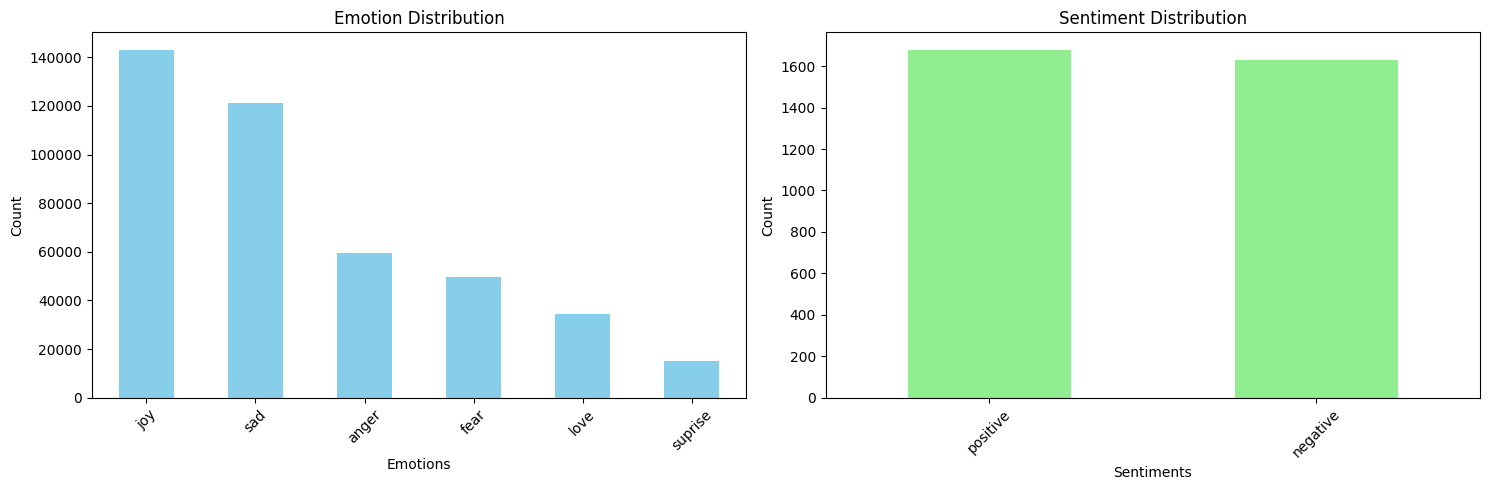

In [4]:
# Step 4: Explore and analyze the datasets
print("🔍 DATA EXPLORATION")
print("=" * 50)

# Emotion dataset analysis
print("\n🎭 EMOTION DATASET ANALYSIS:")
print(f"Total samples: {len(emotion_df)}")
print(f"Columns: {emotion_df.columns.tolist()}")
print("\nEmotion distribution:")
emotion_counts = emotion_df['emotion'].value_counts()
print(emotion_counts)

# Sentiment dataset analysis
print("\n😊 SENTIMENT DATASET ANALYSIS:")
print(f"Total samples: {len(sentiment_df)}")
print(f"Columns: {sentiment_df.columns.tolist()}")
print("\nSentiment distribution:")
sentiment_counts = sentiment_df['sentiment'].value_counts()
print(sentiment_counts)

# Check for missing values
print("\n🔎 MISSING VALUES CHECK:")
print("Emotion dataset missing values:")
print(emotion_df.isnull().sum())
print("\nSentiment dataset missing values:")
print(sentiment_df.isnull().sum())

# Clean the data
emotion_df_clean = emotion_df.dropna()
sentiment_df_clean = sentiment_df.dropna()

print(f"\n✅ After cleaning:")
print(f"Emotion dataset: {len(emotion_df_clean)} samples (removed {len(emotion_df) - len(emotion_df_clean)} missing values)")
print(f"Sentiment dataset: {len(sentiment_df_clean)} samples (removed {len(sentiment_df) - len(sentiment_df_clean)} missing values)")

# Visualize distributions
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

# Emotion distribution plot
emotion_counts.plot(kind='bar', ax=ax1, color='skyblue')
ax1.set_title('Emotion Distribution')
ax1.set_xlabel('Emotions')
ax1.set_ylabel('Count')
ax1.tick_params(axis='x', rotation=45)

# Sentiment distribution plot
sentiment_counts.plot(kind='bar', ax=ax2, color='lightgreen')
ax2.set_title('Sentiment Distribution')
ax2.set_xlabel('Sentiments')
ax2.set_ylabel('Count')
ax2.tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

In [5]:
# Step 5: Create PyTorch Dataset class
class EmotionSentimentDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_length=128):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = str(self.texts[idx])
        label = self.labels[idx]

        encoding = self.tokenizer(
            text,
            truncation=True,
            padding='max_length',
            max_length=self.max_length,
            return_tensors='pt'
        )

        return {
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'labels': torch.tensor(label, dtype=torch.long)
        }

print("✅ Dataset class created successfully!")

✅ Dataset class created successfully!


In [6]:
# Step 6: Train with Tiny Model (Fastest Option)
print("🎭 TRAINING EMOTION CLASSIFICATION MODEL (TINY MODEL)")
print("=" * 50)

# Disable WandB
import os
os.environ["WANDB_DISABLED"] = "true"

# Use smaller subset for faster training
from sklearn.utils import resample
emotion_df_small = resample(emotion_df_clean, n_samples=60000, random_state=42, stratify=emotion_df_clean['emotion'])

# Prepare emotion data
emotion_texts = emotion_df_small['sentence'].tolist()
emotion_labels = emotion_df_small['emotion'].tolist()

# Encode emotion labels
emotion_label_encoder = LabelEncoder()
emotion_encoded_labels = emotion_label_encoder.fit_transform(emotion_labels)

print(f"Emotion classes: {emotion_label_encoder.classes_}")
print(f"Dataset size: {len(emotion_texts)}")

# Split emotion data
train_texts, val_texts, train_labels, val_labels = train_test_split(
    emotion_texts, emotion_encoded_labels, test_size=0.1, random_state=42, stratify=emotion_encoded_labels
)

print(f"Training samples: {len(train_texts)}")
print(f"Validation samples: {len(val_texts)}")

# Use a smaller model
emotion_tokenizer = AutoTokenizer.from_pretrained("prajjwal1/bert-tiny")
emotion_model = AutoModelForSequenceClassification.from_pretrained(
    "prajjwal1/bert-tiny",
    num_labels=len(emotion_label_encoder.classes_)
)
emotion_model.to(device)

# Create datasets
emotion_train_dataset = EmotionSentimentDataset(train_texts, train_labels, emotion_tokenizer)
emotion_val_dataset = EmotionSentimentDataset(val_texts, val_labels, emotion_tokenizer)

# Simple Training arguments
training_args = TrainingArguments(
    output_dir='./results/emotion_results',
    num_train_epochs=3,
    per_device_train_batch_size=32,
    per_device_eval_batch_size=64,
    logging_steps=50,
    save_steps=500,
)

# Create trainer
emotion_trainer = Trainer(
    model=emotion_model,
    args=training_args,
    train_dataset=emotion_train_dataset,
    eval_dataset=emotion_val_dataset,
)

# Start training
print("🚀 Starting training with tiny model...")
print("⏰ This should take 5-10 minutes")

emotion_trainer.train()

print("✅ Emotion model training completed!")

🎭 TRAINING EMOTION CLASSIFICATION MODEL (TINY MODEL)
Emotion classes: ['anger' 'fear' 'joy' 'love' 'sad' 'suprise']
Dataset size: 60000
Training samples: 54000
Validation samples: 6000


Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at prajjwal1/bert-tiny and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


🚀 Starting training with tiny model...
⏰ This should take 5-10 minutes


Step,Training Loss
50,1.680100
100,1.596300
150,1.552100
200,1.495600
250,1.407700
300,1.294900
350,1.231100
400,1.157400
450,1.095700
500,0.979800


✅ Emotion model training completed!



📊 EVALUATING EMOTION MODEL...
🔍 Running evaluation...


Evaluating: 100%|██████████| 188/188 [00:10<00:00, 17.44it/s]


🎭 Emotion Model Accuracy: 0.9077

📈 Emotion Classification Report:
              precision    recall  f1-score   support

       anger       0.92      0.89      0.91       842
        fear       0.86      0.85      0.86       705
         joy       0.95      0.92      0.93      2031
        love       0.80      0.86      0.83       490
         sad       0.94      0.95      0.94      1720
     suprise       0.67      0.85      0.75       212

    accuracy                           0.91      6000
   macro avg       0.86      0.89      0.87      6000
weighted avg       0.91      0.91      0.91      6000



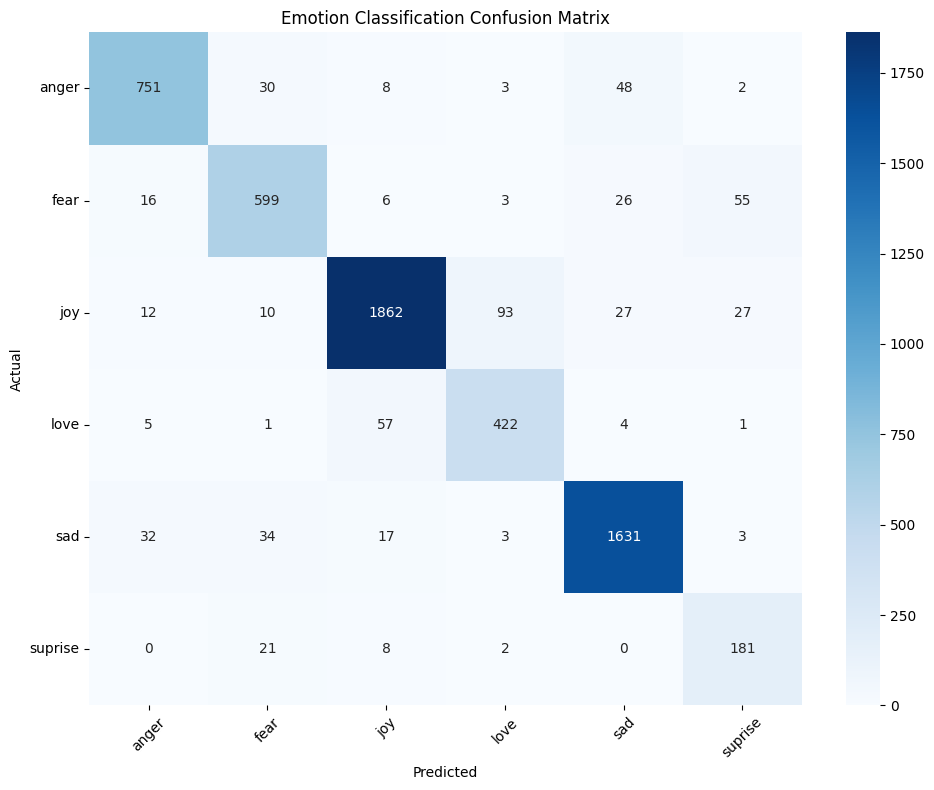

✅ Emotion model saved successfully!


In [7]:
# Step 7: Evaluate Emotion Model and Save
print("\n📊 EVALUATING EMOTION MODEL...")

# Import tqdm for progress bar
from tqdm.auto import tqdm

# Make predictions
emotion_model.eval()
emotion_predictions = []
true_labels = []

print("🔍 Running evaluation...")
with torch.no_grad():
    for batch in tqdm(DataLoader(emotion_val_dataset, batch_size=32), desc="Evaluating"):
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)

        outputs = emotion_model(input_ids=input_ids, attention_mask=attention_mask)
        preds = torch.argmax(outputs.logits, dim=-1)

        emotion_predictions.extend(preds.cpu().numpy())
        true_labels.extend(labels.cpu().numpy())

# Calculate metrics
emotion_accuracy = accuracy_score(true_labels, emotion_predictions)
print(f"🎭 Emotion Model Accuracy: {emotion_accuracy:.4f}")

# Classification report
print("\n📈 Emotion Classification Report:")
print(classification_report(true_labels, emotion_predictions,
                          target_names=emotion_label_encoder.classes_))

# Confusion matrix
plt.figure(figsize=(10, 8))
cm = confusion_matrix(true_labels, emotion_predictions)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=emotion_label_encoder.classes_,
            yticklabels=emotion_label_encoder.classes_)
plt.title('Emotion Classification Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

# Save emotion model
emotion_model.save_pretrained('./models/emotion_model')
emotion_tokenizer.save_pretrained('./models/emotion_model')
print("✅ Emotion model saved successfully!")

In [9]:
# Step 8: Train Sentiment Classification Model
print("\n😊 TRAINING SENTIMENT CLASSIFICATION MODEL")
print("=" * 50)

# Disable WandB
import os
os.environ["WANDB_DISABLED"] = "true"

# Use cleaned data
sentiment_df = sentiment_df_clean

# Prepare sentiment data
sentiment_texts = sentiment_df['sentence'].tolist()
sentiment_labels = sentiment_df['sentiment'].tolist()

# Encode sentiment labels
sentiment_label_encoder = LabelEncoder()
sentiment_encoded_labels = sentiment_label_encoder.fit_transform(sentiment_labels)

print(f"Sentiment classes: {sentiment_label_encoder.classes_}")
print(f"Number of sentiment classes: {len(sentiment_label_encoder.classes_)}")
print(f"Dataset size: {len(sentiment_texts)}")

# Split sentiment data
train_texts, val_texts, train_labels, val_labels = train_test_split(
    sentiment_texts, sentiment_encoded_labels, test_size=0.1, random_state=42, stratify=sentiment_encoded_labels
)

print(f"Training samples: {len(train_texts)}")
print(f"Validation samples: {len(val_texts)}")

# Initialize tokenizer and model
sentiment_tokenizer = AutoTokenizer.from_pretrained("distilbert-base-uncased")
sentiment_model = AutoModelForSequenceClassification.from_pretrained(
    "distilbert-base-uncased",
    num_labels=len(sentiment_label_encoder.classes_)
)
sentiment_model.to(device)

# Create datasets
sentiment_train_dataset = EmotionSentimentDataset(train_texts, train_labels, sentiment_tokenizer)
sentiment_val_dataset = EmotionSentimentDataset(val_texts, val_labels, sentiment_tokenizer)

# Simple Training arguments
training_args = TrainingArguments(
    output_dir='./results/sentiment_results',
    num_train_epochs=2,
    per_device_train_batch_size=32,
    per_device_eval_batch_size=64,
    logging_steps=100,
    save_steps=1000,
    report_to=None,
)

# Create trainer
sentiment_trainer = Trainer(
    model=sentiment_model,
    args=training_args,
    train_dataset=sentiment_train_dataset,
    eval_dataset=sentiment_val_dataset,
)

# Start training
print("🚀 Starting sentiment model training...")
print("⏰ This should take 5-10 minutes...")
sentiment_trainer.train()

print("✅ Sentiment model training completed!")


😊 TRAINING SENTIMENT CLASSIFICATION MODEL
Sentiment classes: ['negative' 'positive']
Number of sentiment classes: 2
Dataset size: 3309
Training samples: 2978
Validation samples: 331


Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`
Error while downloading from https://huggingface.co/distilbert-base-uncased/resolve/main/model.safetensors: HTTPSConnectionPool(host='cas-bridge.xethub.hf.co', port=443): Read timed out.
Trying to resume download...
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).


🚀 Starting sentiment model training...
⏰ This should take 5-10 minutes...


Step,Training Loss
100,0.306900


✅ Sentiment model training completed!



📊 EVALUATING SENTIMENT MODEL...
🔍 Running evaluation...


Evaluating: 100%|██████████| 11/11 [00:30<00:00,  2.73s/it]


😊 Sentiment Model Accuracy: 0.9396

📈 Sentiment Classification Report:
              precision    recall  f1-score   support

    negative       0.91      0.98      0.94       163
    positive       0.97      0.90      0.94       168

    accuracy                           0.94       331
   macro avg       0.94      0.94      0.94       331
weighted avg       0.94      0.94      0.94       331



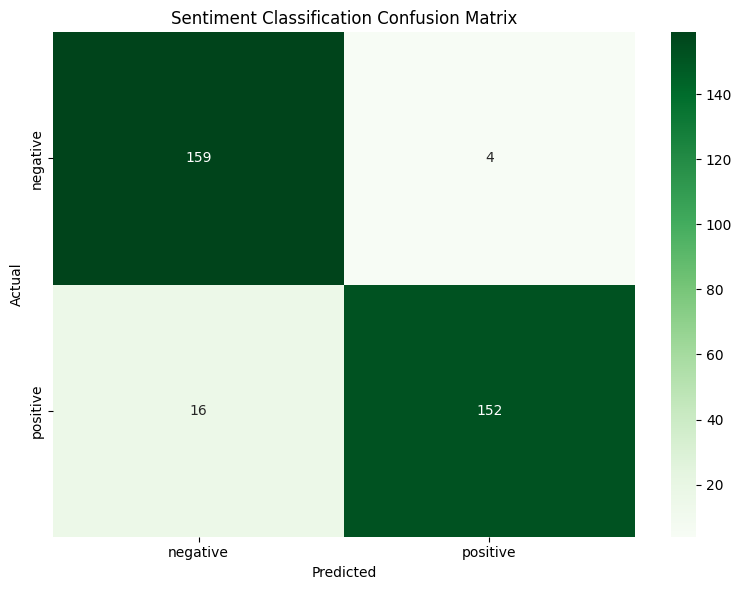

✅ Sentiment model saved successfully!


In [10]:
# Step 9: Evaluate Sentiment Model and Save
print("\n📊 EVALUATING SENTIMENT MODEL...")

# Make predictions
sentiment_model.eval()
sentiment_predictions = []
true_labels = []

print("🔍 Running evaluation...")
with torch.no_grad():
    for batch in tqdm(DataLoader(sentiment_val_dataset, batch_size=32), desc="Evaluating"):
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)

        outputs = sentiment_model(input_ids=input_ids, attention_mask=attention_mask)
        preds = torch.argmax(outputs.logits, dim=-1)

        sentiment_predictions.extend(preds.cpu().numpy())
        true_labels.extend(labels.cpu().numpy())

# Calculate metrics
sentiment_accuracy = accuracy_score(true_labels, sentiment_predictions)
print(f"😊 Sentiment Model Accuracy: {sentiment_accuracy:.4f}")

# Classification report
print("\n📈 Sentiment Classification Report:")
print(classification_report(true_labels, sentiment_predictions,
                          target_names=sentiment_label_encoder.classes_))

# Confusion matrix
plt.figure(figsize=(8, 6))
cm = confusion_matrix(true_labels, sentiment_predictions)
sns.heatmap(cm, annot=True, fmt='d', cmap='Greens',
            xticklabels=sentiment_label_encoder.classes_,
            yticklabels=sentiment_label_encoder.classes_)
plt.title('Sentiment Classification Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.tight_layout()
plt.show()

# Save sentiment model
sentiment_model.save_pretrained('./models/sentiment_model')
sentiment_tokenizer.save_pretrained('./models/sentiment_model')
print("✅ Sentiment model saved successfully!")

In [ ]:

print("\n💾 SAVING LABEL ENCODERS...")

import joblib

# Save emotion label encoder
joblib.dump(emotion_label_encoder, './models/emotion_label_encoder.pkl')
print("✅ Emotion label encoder saved!")

# Save sentiment label encoder
joblib.dump(sentiment_label_encoder, './models/sentiment_label_encoder.pkl')
print("✅ Sentiment label encoder saved!")

# Verify the files were created
import os
print(f"📁 Emotion encoder exists: {os.path.exists('./models/emotion_label_encoder.pkl')}")
print(f"📁 Sentiment encoder exists: {os.path.exists('./models/sentiment_label_encoder.pkl')}")

In [ ]:

print("\n💾 SAVING SENTIMENT LABEL ENCODERS...")

# Save sentiment label encoder (already done above, but let's confirm)
joblib.dump(sentiment_label_encoder, './models/sentiment_label_encoder.pkl')
print("✅ Sentiment label encoder saved!")

# Verify all files exist
required_files = [
    './models/emotion_model',
    './models/sentiment_model',
    './models/emotion_label_encoder.pkl',
    './models/sentiment_label_encoder.pkl'
]

print("\n🔍 VERIFYING ALL MODEL FILES:")
for file_path in required_files:
    exists = os.path.exists(file_path)
    status = "✅ Found" if exists else "❌ Missing"
    print(f"{status}: {file_path}")

if all(os.path.exists(f) for f in required_files):
    print("\n🎉 All model files are ready! You can now run the Streamlit app.")
else:
    print("\n⚠️ Some files are still missing. Please check the training steps.")


💾 SAVING SENTIMENT LABEL ENCODERS...
✅ Sentiment label encoder saved!

🔍 VERIFYING ALL MODEL FILES:
✅ Found: ./models/emotion_model
✅ Found: ./models/sentiment_model
✅ Found: ./models/emotion_label_encoder.pkl
✅ Found: ./models/sentiment_label_encoder.pkl

🎉 All model files are ready! You can now run the Streamlit app.


In [12]:
# Step 10: Create the Dynamic AI Chatbot Class
print("\n🤖 CREATING DYNAMIC AI CHATBOT")
print("=" * 50)

class DynamicAIChatbot:
    def __init__(self, emotion_model_path, sentiment_model_path):
        # Load emotion model
        self.emotion_tokenizer = AutoTokenizer.from_pretrained(emotion_model_path)
        self.emotion_model = AutoModelForSequenceClassification.from_pretrained(emotion_model_path)
        self.emotion_model.to(device)
        self.emotion_model.eval()

        # Load sentiment model
        self.sentiment_tokenizer = AutoTokenizer.from_pretrained(sentiment_model_path)
        self.sentiment_model = AutoModelForSequenceClassification.from_pretrained(sentiment_model_path)
        self.sentiment_model.to(device)
        self.sentiment_model.eval()

        # Conversation history
        self.conversation_history = []

        # Response templates based on emotion and sentiment
        self.response_templates = {
            'positive': {
                'joy': "That's wonderful! I'm happy to hear that! 😊",
                'love': "That's so heartwarming! Love is beautiful! ❤️",
                'surprise': "Wow! That's amazing news! 🎉",
                'neutral': "Thanks for sharing! That's great to know! 👍",
                'sad': "I'm glad things are looking up! 🌟",
                'anger': "It's great you're channeling that energy positively! 💪",
                'fear': "I'm happy you're feeling more secure now! 🛡️"
            },
            'negative': {
                'joy': "Even in difficult times, finding joy is important 🌈",
                'love': "Love can be complicated, but it's worth it 💔",
                'surprise': "Unexpected challenges can be tough to handle 😔",
                'neutral': "I understand this is difficult. I'm here for you 🫂",
                'sad': "I'm sorry you're feeling this way. You're not alone 💙",
                'anger': "I understand you're upset. Let's work through this together 🔥",
                'fear': "It's okay to feel scared. You're stronger than you think 🤗"
            },
            'neutral': {
                'joy': "Glad things are going well for you! 😊",
                'love': "That sounds nice! ❤️",
                'surprise': "Interesting! Tell me more about that! 🤔",
                'neutral': "Thanks for sharing! How can I assist you further? 👍",
                'sad': "I'm here to listen if you want to talk more 💙",
                'anger': "I understand your frustration 🫂",
                'fear': "It's okay, we'll figure this out together 🤗"
            }
        }

        print("✅ Dynamic AI Chatbot initialized successfully!")

    def predict_emotion(self, text):
        """Predict emotion from text"""
        inputs = self.emotion_tokenizer(
            text,
            return_tensors="pt",
            truncation=True,
            padding=True,
            max_length=128
        )
        inputs = {k: v.to(device) for k, v in inputs.items()}

        with torch.no_grad():
            outputs = self.emotion_model(**inputs)
            predictions = torch.nn.functional.softmax(outputs.logits, dim=-1)
            predicted_class = torch.argmax(predictions, dim=1).cpu().numpy()[0]

        emotion = emotion_label_encoder.inverse_transform([predicted_class])[0]
        confidence = predictions.cpu().numpy()[0][predicted_class]

        return emotion, confidence

    def predict_sentiment(self, text):
        """Predict sentiment from text"""
        inputs = self.sentiment_tokenizer(
            text,
            return_tensors="pt",
            truncation=True,
            padding=True,
            max_length=128
        )
        inputs = {k: v.to(device) for k, v in inputs.items()}

        with torch.no_grad():
            outputs = self.sentiment_model(**inputs)
            predictions = torch.nn.functional.softmax(outputs.logits, dim=-1)
            predicted_class = torch.argmax(predictions, dim=1).cpu().numpy()[0]

        sentiment = sentiment_label_encoder.inverse_transform([predicted_class])[0]
        confidence = predictions.cpu().numpy()[0][predicted_class]

        return sentiment, confidence

    def generate_response(self, user_input, emotion, sentiment, confidence):
        """Generate contextual response based on emotion and sentiment"""
        # Store conversation
        self.conversation_history.append({
            'user_input': user_input,
            'emotion': emotion,
            'sentiment': sentiment,
            'confidence': confidence,
            'timestamp': pd.Timestamp.now()
        })

        # Generate contextual response
        if sentiment in self.response_templates and emotion in self.response_templates[sentiment]:
            base_response = self.response_templates[sentiment][emotion]
        else:
            base_response = "Thank you for sharing. How can I help you today? 🤗"

        # Add contextual follow-up based on emotion
        follow_ups = {
            'joy': " Is there anything else making you happy today?",
            'love': " Would you like to share more about what you love?",
            'surprise': " What was the most surprising part?",
            'neutral': " Is there anything specific you'd like to discuss?",
            'sad': " Would it help to talk more about what's on your mind?",
            'anger': " Would you like to talk more about what's bothering you?",
            'fear': " What would help you feel more secure about this?"
        }

        follow_up = follow_ups.get(emotion, " How can I assist you further?")

        return base_response + follow_up

    def chat(self, user_input):
        """Main chat method"""
        # Predict emotion and sentiment
        emotion, emotion_confidence = self.predict_emotion(user_input)
        sentiment, sentiment_confidence = self.predict_sentiment(user_input)

        print(f"\n🔍 Analysis:")
        print(f"   Emotion: {emotion} (confidence: {emotion_confidence:.3f})")
        print(f"   Sentiment: {sentiment} (confidence: {sentiment_confidence:.3f})")

        # Generate response
        response = self.generate_response(user_input, emotion, sentiment,
                                        min(emotion_confidence, sentiment_confidence))

        return response

    def get_conversation_summary(self):
        """Get summary of current conversation"""
        if not self.conversation_history:
            return "No conversation history yet."

        emotions = [entry['emotion'] for entry in self.conversation_history]
        sentiments = [entry['sentiment'] for entry in self.conversation_history]

        summary = {
            'total_messages': len(self.conversation_history),
            'dominant_emotion': max(set(emotions), key=emotions.count),
            'dominant_sentiment': max(set(sentiments), key=sentiments.count),
            'emotion_distribution': {emotion: emotions.count(emotion) for emotion in set(emotions)},
            'sentiment_distribution': {sentiment: sentiments.count(sentiment) for sentiment in set(sentiments)},
            'average_confidence': np.mean([entry['confidence'] for entry in self.conversation_history])
        }

        return summary

    def clear_history(self):
        """Clear conversation history"""
        self.conversation_history = []
        print("🗑️ Conversation history cleared!")

print("✅ Chatbot class created successfully!")


🤖 CREATING DYNAMIC AI CHATBOT
✅ Chatbot class created successfully!


In [13]:
# Step 11: Initialize and Test the Chatbot
print("🚀 INITIALIZING CHATBOT...")

# Initialize chatbot
chatbot = DynamicAIChatbot('./models/emotion_model', './models/sentiment_model')

# Test the chatbot with sample inputs
print("\n🧪 TESTING CHATBOT WITH SAMPLE INPUTS...")
print("=" * 50)

test_inputs = [
    "I'm so happy today! I got a promotion at work!",
    "I feel really sad and lonely right now.",
    "I'm angry about what happened yesterday.",
    "This is amazing news, I can't believe it!",
    "I'm scared about the upcoming presentation.",
    "I love spending time with my family.",
    "Today was just an ordinary day, nothing special.",
    "I'm feeling disappointed about the results."
]

for i, test_input in enumerate(test_inputs, 1):
    print(f"\nTest {i}:")
    print(f"👤 User: {test_input}")
    response = chatbot.chat(test_input)
    print(f"🤖 Bot: {response}")
    print("-" * 80)

print("✅ Chatbot testing completed!")

🚀 INITIALIZING CHATBOT...
✅ Dynamic AI Chatbot initialized successfully!

🧪 TESTING CHATBOT WITH SAMPLE INPUTS...

Test 1:
👤 User: I'm so happy today! I got a promotion at work!

🔍 Analysis:
   Emotion: joy (confidence: 0.980)
   Sentiment: positive (confidence: 0.989)
🤖 Bot: That's wonderful! I'm happy to hear that! 😊 Is there anything else making you happy today?
--------------------------------------------------------------------------------

Test 2:
👤 User: I feel really sad and lonely right now.

🔍 Analysis:
   Emotion: sad (confidence: 0.976)
   Sentiment: negative (confidence: 0.983)
🤖 Bot: I'm sorry you're feeling this way. You're not alone 💙 Would it help to talk more about what's on your mind?
--------------------------------------------------------------------------------

Test 3:
👤 User: I'm angry about what happened yesterday.

🔍 Analysis:
   Emotion: anger (confidence: 0.947)
   Sentiment: negative (confidence: 0.987)
🤖 Bot: I understand you're upset. Let's work through t

In [ ]:
# Step 12: Interactive Chat Session
print("\n💬 INTERACTIVE CHAT SESSION")
print("=" * 50)
print("Welcome to the Dynamic AI Chatbot!")
print("🤖 I can understand your emotions and sentiments!")
print("\n💡 Commands:")
print("   - Type 'quit' to exit")
print("   - Type 'summary' to see conversation summary")
print("   - Type 'clear' to clear conversation history")
print("   - Type 'help' to see this message again")
print("\nLet's start chatting! 👇")

while True:
    user_input = input("\n👤 You: ").strip()

    if user_input.lower() == 'quit':
        print("👋 Thank you for chatting with me! Have a great day! 🌟")
        break
    elif user_input.lower() == 'summary':
        summary = chatbot.get_conversation_summary()
        print("\n📊 Conversation Summary:")
        for key, value in summary.items():
            print(f"   {key}: {value}")
        continue
    elif user_input.lower() == 'clear':
        chatbot.clear_history()
        continue
    elif user_input.lower() == 'help':
        print("\n💡 Available Commands:")
        print("   - 'quit': Exit the chat")
        print("   - 'summary': Show conversation summary")
        print("   - 'clear': Clear conversation history")
        print("   - 'help': Show this help message")
        continue
    elif user_input == '':
        print("🤖 Please type something to chat with me!")
        continue

    try:
        response = chatbot.chat(user_input)
        print(f"🤖 Bot: {response}")
    except Exception as e:
        print(f"❌ Error: {e}")
        print("🤖 I'm having trouble understanding. Could you rephrase that?")

print("\n📝 Final Conversation Summary:")
final_summary = chatbot.get_conversation_summary()
for key, value in final_summary.items():
    print(f"   {key}: {value}")


💬 INTERACTIVE CHAT SESSION
Welcome to the Dynamic AI Chatbot!
🤖 I can understand your emotions and sentiments!

💡 Commands:
   - Type 'quit' to exit
   - Type 'summary' to see conversation summary
   - Type 'clear' to clear conversation history
   - Type 'help' to see this message again

Let's start chatting! 👇


In [ ]:
# Step 13: Save Complete Project
print("\n💾 SAVING COMPLETE PROJECT...")

# Define the base directory for saving in Google Drive
drive_save_dir = "C:\Users\ganes\OneDrive\Desktop\emotion" # Change this path if needed

# Create the directory in Google Drive if it doesn't exist
os.makedirs(drive_save_dir, exist_ok=True)
os.makedirs(os.path.join(drive_save_dir, 'models'), exist_ok=True)
os.makedirs(os.path.join(drive_save_dir, 'results'), exist_ok=True) # Also create results dir in drive

# Save label encoders to Google Drive
joblib.dump(emotion_label_encoder, os.path.join(drive_save_dir, 'models', 'emotion_label_encoder.pkl'))
joblib.dump(sentiment_label_encoder, os.path.join(drive_save_dir, 'models', 'sentiment_label_encoder.pkl'))

# Save chatbot configuration to Google Drive
chatbot_config = {
    'emotion_classes': emotion_label_encoder.classes_.tolist(),
    'sentiment_classes': sentiment_label_encoder.classes_.tolist(),
    'emotion_accuracy': emotion_accuracy,
    'sentiment_accuracy': sentiment_accuracy,
    'model_paths': {
        'emotion_model': os.path.join(drive_save_dir, 'models', 'emotion_model'),
        'sentiment_model': os.path.join(drive_save_dir, 'models', 'sentiment_model')
    }
}

import json
with open(os.path.join(drive_save_dir, 'models', 'chatbot_config.json'), 'w') as f:
    json.dump(chatbot_config, f, indent=2)

# Create requirements file in Google Drive
requirements = """
torch>=2.0.0
transformers>=4.30.0
pandas>=1.5.0
scikit-learn>=1.2.0
matplotlib>=3.5.0
seaborn>=0.12.0
numpy>=1.21.0
joblib>=1.2.0
accelerate>=0.20.0
tqdm>=4.64.0
"""

with open(os.path.join(drive_save_dir, 'requirements.txt'), 'w') as f:
    f.write(requirements)

# Save models to Google Drive
emotion_model.save_pretrained(os.path.join(drive_save_dir, 'models', 'emotion_model'))
emotion_tokenizer.save_pretrained(os.path.join(drive_save_dir, 'models', 'emotion_model'))

sentiment_model.save_pretrained(os.path.join(drive_save_dir, 'models', 'sentiment_model'))
sentiment_tokenizer.save_pretrained(os.path.join(drive_save_dir, 'models', 'sentiment_model'))


print(f"✅ Project files saved successfully to {drive_save_dir}!")

# Display project structure (as if saved locally for clarity, but the saving is to Drive)
print("\n📁 SAVED PROJECT STRUCTURE (in Google Drive):")
print(f"{drive_save_dir}/")
print("├── models/")
print("│   ├── emotion_model/")
print("│   ├── sentiment_model/")
print("│   ├── emotion_label_encoder.pkl")
print("│   ├── sentiment_label_encoder.pkl")
print("│   └── chatbot_config.json")
print("├── results/")
print("└── requirements.txt")